# Introduction to Scikit-Learn: Machine Learning with Python

**Validation and Model Selection**

郭耀仁

## Validation

## About validation

One of the most important pieces of machine learning is **model validation**: that is, checking how well your model fits a given dataset.

## Consider the Titanic example we've been looking at previously

How might we check how well our model fits the data?

In [1]:
import pandas as pd
from sklearn.preprocessing import Imputer

train_url = "https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv"
train = pd.read_csv(train_url)
X_train = train[["Fare", "Age"]].values
imputer = Imputer(strategy="median")
X_train = imputer.fit_transform(X_train)
y_train = train.loc[:, "Survived"].values

## Let's fit a K-neighbors classifier

In [2]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

## Now we'll use this classifier to *predict* labels for the data

In [3]:
y_pred = knn.predict(X_train)

## Finally, we can check how well our prediction did:

In [4]:
import numpy as np

print("{0} / {1} correct".format(np.sum(y_train == y_pred), len(y_train)))

682 / 891 correct


It seems we have a pretty good classifier!

**Question: what's wrong with this?**

## Validation Sets

## About validation sets

Above we made the mistake of testing our data on the same set of data that was used for training. **This is not generally a good idea**. If we optimize our estimator this way, we will tend to **over-fit** the data: that is, we learn the noise.

## A better way to test a model is to use a hold-out set which doesn't enter the training

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

(668, 2)
(223, 2)


## Now we train on the training data, and validate on the test data

In [6]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

150 / 223 correct


## This gives us a more reliable estimate of how our model is doing

The metric we're using here, comparing the number of matches to the total number of samples, is known as the **accuracy score**, and can be computed using the following routine:

In [7]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.67264573991031396

## This can also be computed directly from the ``model.score`` method

In [8]:
knn.score(X_test, y_test)

0.67264573991031396

## Validation metrics used for classification

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), or the matrix showing the frequency of inputs and outputs:

In [9]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[108  29]
 [ 44  42]]


## Validation metrics used for regression

$$MSE = \frac{1}{m}\sum_{i=1}^m(\hat{y_i} - y_i) ^ 2$$

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train_url = "https://storage.googleapis.com/kaggle_datasets/House-Prices-Advanced-Regression-Techniques/train.csv"
train_df = pd.read_csv(train_url)
X_train = train_df["GrLivArea"].values.reshape(-1, 1)
y_train = train_df["SalePrice"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)
reg = LinearRegression()
reg.fit(X_train, y_train)
print(mean_squared_error(y_test, reg.predict(X_test)))

3737846159.23


## Cross-Validation

## One problem with validation sets

We "lose" some of the data. Above, we've only used 3/4 of the data for the training, and used 1/4 for the validation. Another option is to use **2-fold cross-validation**, where we split the sample in half and perform the validation twice:

In [11]:
train_url = "https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv"
train = pd.read_csv(train_url)
X_train = train[["Fare", "Age"]].values
imputer = Imputer(strategy="median")
X_train = imputer.fit_transform(X_train)
y_train = train.loc[:, "Survived"].values

X1, X2, y1, y2 = train_test_split(X_train, y_train, test_size=0.5, random_state=0)
print(X1.shape)
print(X2.shape)

(445, 2)
(446, 2)


In [12]:
print(KNeighborsClassifier().fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier().fit(X1, y1).score(X2, y2))

0.631460674157
0.650224215247


## A two-fold cross-validation gives us two estimates of the score for that parameter

Because this is a bit of a pain to do by hand, scikit-learn has a utility routine to help:

In [13]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=10)
cv.mean()

0.66923334468278295

### K-fold Cross-Validation

Here we've used 2-fold cross-validation. This is just one specialization of $K$-fold cross-validation, where we split the data into $K$ chunks and perform $K$ fits, where each chunk gets a turn as the validation set.
We can do this by changing the ``cv`` parameter above. Let's do 10-fold cross-validation:

In [14]:
cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=10)

array([ 0.56666667,  0.61111111,  0.68539326,  0.6741573 ,  0.62921348,
        0.71910112,  0.70786517,  0.71910112,  0.58426966,  0.79545455])

## Overfitting, Underfitting and Model Selection

## The importance

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.

## If our estimator is underperforming, how should we move forward?

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

## The answer is often counter-intuitive

In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

## Illustration of the Bias-Variance Tradeoff

In [15]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [16]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

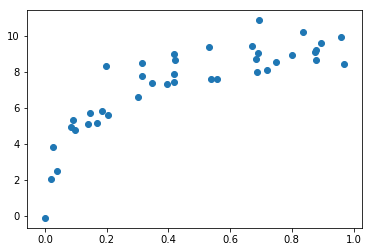

In [17]:
import matplotlib.pyplot as plt

X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y)
plt.show()

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

In [18]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))

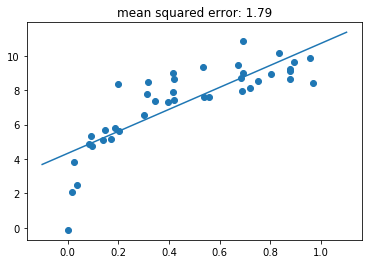

In [19]:
plt.show()

## We have fit a straight line to the data, but clearly this model is not a good choice

We say that this model is **biased**, or that it **under-fits** the data.

## Let's try to improve this by creating a more complicated model

We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Now we'll use this to fit a quadratic curve to the data.

In [21]:
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))

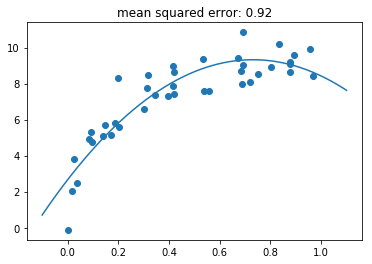

In [22]:
plt.show()

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

In [23]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14)

(-4, 14)

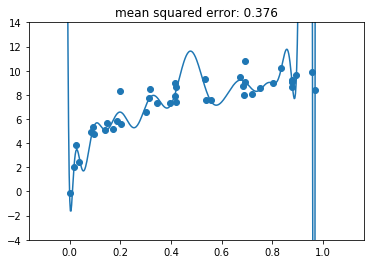

In [24]:
plt.show()

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

## Detecting Over-fitting with Validation Curves

## Computing the error on the training data is not enough

As above, we can use **cross-validation** to get a better handle on how the model fit is working.

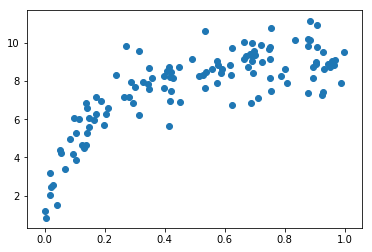

In [25]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y)
plt.show()

In [26]:
from sklearn.model_selection import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7, scoring=rms_error)

Now let's plot the validation curves:

In [27]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend()

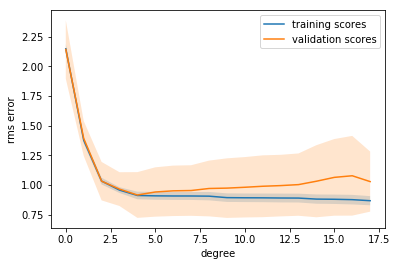

In [28]:
plt.show()

## Notice the trend here

1. For a small model complexity, the training error and validation error are very similar. This indicates that the model is **under-fitting** the data: it doesn't have enough complexity to represent the data. Another way of putting it is that this is a **high-bias** model.

2. As the model complexity grows, the training and validation scores diverge. This indicates that the model is **over-fitting** the data: it has so much flexibility, that it fits the noise rather than the underlying trend. Another way of putting it is that this is a **high-variance** model.

3. Note that the training score (nearly) always improves with model complexity. This is because a more complicated model can fit the noise better, so the model improves. The validation data generally has a sweet spot, which here is around 5 terms.

Here's our best-fit model according to the cross-validation:

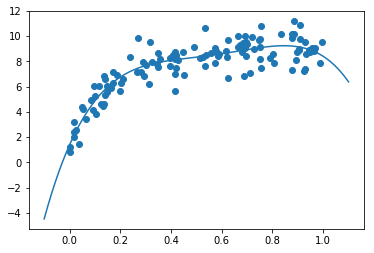

In [29]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test))
plt.show()